In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
x_train = x_train / 255
x_test = x_test / 255

In [10]:
len(x_train)

60000

In [11]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [40]:
hidden_dim = 2
batch_size = 60

def dropout_and_bacthnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_image = Input(batch_shape = (batch_size, 28, 28, 1))
x = Flatten()(input_image)
x = Dense(256, activation='relu')(x)
x = dropout_and_bacthnorm(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_bacthnorm(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_bacthnorm(d)
d = Dense(256, activation='relu')(input_dec)
d = dropout_and_bacthnorm(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_image, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
vae = keras.Model(input_image, decoder(encoder(input_image)), name='vae')


In [41]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [42]:
vae.fit(x_train, x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 10s 6ms/step - loss: 58.5172
Epoch 2/5
1000/1000 [==============================] - 6s 6ms/step - loss: 43.7135
Epoch 3/5
1000/1000 [==============================] - 7s 7ms/step - loss: 43.1871
Epoch 4/5
1000/1000 [==============================] - 7s 7ms/step - loss: 42.8710
Epoch 5/5
1000/1000 [==============================] - 10s 10ms/step - loss: 42.7459


100/100 [==============================] - 0s 2ms/step


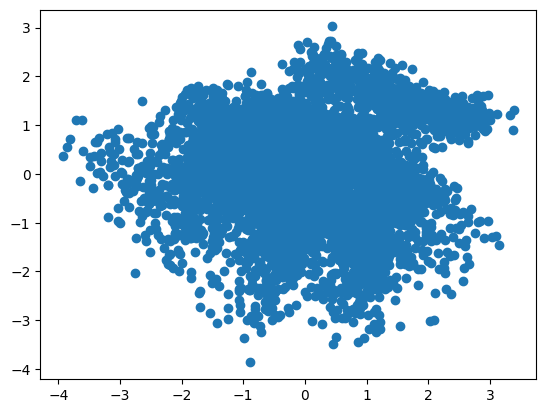

In [43]:
h = encoder.predict(x_test[:6000], batch_size=batch_size)
plt.scatter(h[:,0], h[:,1])

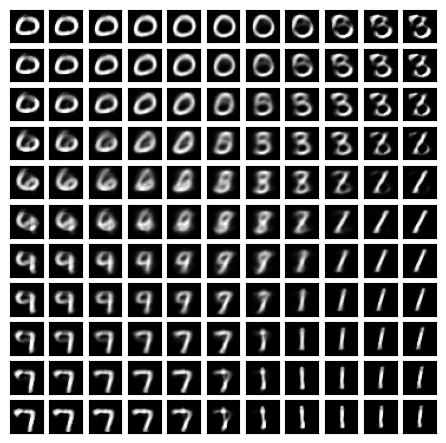

In [46]:
n = 5
total = 2 * n + 1

plt.figure(figsize=(total/2, total/2))
num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0), verbose=False)
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)